# Clustering Crypto

In [55]:
# Initial imports
!pip install hvplot
import requests
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.pandas
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from pathlib import Path


### Fetching Cryptocurrency Data

In [56]:
# Alternatively, use the provided csv file:
file_path = Path("crypto_data.csv")

# Create a DataFrame

crypto_df = pd.read_csv(file_path, index_col='Unnamed: 0')

In [57]:
# Use the following endpoint to fetch json data
# url = "https://min-api.cryptocompare.com/data/all/coinlist"

In [58]:
# Create a DataFrame 
# HINT: You will need to use the 'Data' key from the json response, then transpose the DataFrame.

In [59]:
crypto_df

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
365,365Coin,X11,True,PoW/PoS,NaN,2300000000
404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
611,SixEleven,SHA-256,True,PoW,NaN,611000
808,808,SHA-256,True,PoW/PoS,0.000000e+00,0
...,...,...,...,...,...,...
XBC,BitcoinPlus,Scrypt,True,PoS,1.283270e+05,1000000
DVTC,DivotyCoin,Scrypt,False,PoW/PoS,2.149121e+07,100000000
GIOT,Giotto Coin,Scrypt,False,PoW/PoS,NaN,233100000
OPSC,OpenSourceCoin,SHA-256,False,PoW/PoS,NaN,21000000


### Data Preprocessing

In [60]:
# Keep only necessary columns:
# 'CoinName','Algorithm','IsTrading','ProofType','TotalCoinsMined','TotalCoinSupply'
# crypto_df = crypto_df.drop(columns='Unnamed: 0')

In [61]:
# Keep only cryptocurrencies that are trading
crypto_df = crypto_df.loc[crypto_df['IsTrading']==True]

In [62]:
# Keep only cryptocurrencies with a working algorithm
crypto_df = crypto_df.loc[crypto_df['Algorithm'] != 'N/A']

In [63]:
# Remove the "IsTrading" column
crypto_df = crypto_df.drop(columns= 'IsTrading')

In [64]:
# Remove rows with at least 1 null value
crypto_df= crypto_df.dropna()

In [65]:
crypto_df.isnull().sum()

CoinName           0
Algorithm          0
ProofType          0
TotalCoinsMined    0
TotalCoinSupply    0
dtype: int64

In [66]:
# Remove rows with cryptocurrencies having no coins mined
crypto_df = crypto_df.loc[crypto_df['TotalCoinsMined'] != 0]

In [67]:
# Drop rows where there are 'N/A' text values
crypto_df = crypto_df[crypto_df != 'N/A']

In [68]:
crypto_df

,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,PoW/PoS,4.199995e+01,42
404,404Coin,Scrypt,PoW/PoS,1.055185e+09,532000000
1337,EliteCoin,X13,PoW/PoS,2.927942e+10,314159265359
BTC,Bitcoin,SHA-256,PoW,1.792718e+07,21000000
ETH,Ethereum,Ethash,PoW,1.076842e+08,0
...,...,...,...,...,...
ZEPH,ZEPHYR,SHA-256,DPoS,2.000000e+09,2000000000
GAP,Gapcoin,Scrypt,PoW/PoS,1.493105e+07,250000000
BDX,Beldex,CryptoNight,PoW,9.802226e+08,1400222610
ZEN,Horizen,Equihash,PoW,7.296538e+06,21000000


In [69]:
# Store the 'CoinName'column in its own DataFrame prior to dropping it from crypto_df
coin_name_df = pd.DataFrame(
    data=crypto_df,
    index=crypto_df.index,
    columns=['CoinName']
)

In [70]:
coin_name_df


,CoinName
42,42 Coin
404,404Coin
1337,EliteCoin
BTC,Bitcoin
ETH,Ethereum
...,...
ZEPH,ZEPHYR
GAP,Gapcoin
BDX,Beldex
ZEN,Horizen


In [71]:
# Drop the 'CoinName' column since it's not going to be used on the clustering algorithm
crypto_df = crypto_df.drop(columns='CoinName')

In [72]:
crypto_df['TotalCoinSupply']= crypto_df['TotalCoinSupply'].astype('float64')

In [73]:
crypto_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 533 entries, 42 to XBC
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Algorithm        533 non-null    object 
 1   ProofType        533 non-null    object 
 2   TotalCoinsMined  533 non-null    float64
 3   TotalCoinSupply  533 non-null    float64
dtypes: float64(2), object(2)
memory usage: 20.8+ KB


In [74]:
# Create dummy variables for text features
X = pd.get_dummies(crypto_df)

In [75]:
X

,TotalCoinsMined,TotalCoinSupply,Algorithm_1GB AES Pattern Search,Algorithm_536,Algorithm_Argon2d,Algorithm_BLAKE256,Algorithm_Blake,Algorithm_Blake2S,Algorithm_Blake2b,Algorithm_C11,...,ProofType_PoW/PoS,ProofType_PoW/PoS,ProofType_PoW/PoW,ProofType_PoW/nPoS,ProofType_Pos,ProofType_Proof of Authority,ProofType_Proof of Trust,ProofType_TPoS,ProofType_Zero-Knowledge Proof,ProofType_dPoW/PoW
42,4.199995e+01,4.200000e+01,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
404,1.055185e+09,5.320000e+08,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1337,2.927942e+10,3.141593e+11,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
BTC,1.792718e+07,2.100000e+07,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ETH,1.076842e+08,0.000000e+00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZEPH,2.000000e+09,2.000000e+09,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GAP,1.493105e+07,2.500000e+08,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
BDX,9.802226e+08,1.400223e+09,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZEN,7.296538e+06,2.100000e+07,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [76]:
# Standardize data
scaled_crypto = StandardScaler().fit_transform(X)

In [77]:
scaled_crypto_df = pd.DataFrame(
    data= scaled_crypto,
    index=X.index,
    columns=X.columns
)

In [78]:
scaled_crypto_df

,TotalCoinsMined,TotalCoinSupply,Algorithm_1GB AES Pattern Search,Algorithm_536,Algorithm_Argon2d,Algorithm_BLAKE256,Algorithm_Blake,Algorithm_Blake2S,Algorithm_Blake2b,Algorithm_C11,...,ProofType_PoW/PoS,ProofType_PoW/PoS,ProofType_PoW/PoW,ProofType_PoW/nPoS,ProofType_Pos,ProofType_Proof of Authority,ProofType_Proof of Trust,ProofType_TPoS,ProofType_Zero-Knowledge Proof,ProofType_dPoW/PoW
42,-0.116748,-0.152865,-0.043355,-0.043355,-0.043355,-0.061372,-0.075235,-0.043355,-0.061372,-0.061372,...,1.424222,-0.043355,-0.043355,-0.043355,-0.043355,-0.043355,-0.043355,-0.043355,-0.043355,-0.043355
404,-0.093589,-0.144996,-0.043355,-0.043355,-0.043355,-0.061372,-0.075235,-0.043355,-0.061372,-0.061372,...,1.424222,-0.043355,-0.043355,-0.043355,-0.043355,-0.043355,-0.043355,-0.043355,-0.043355,-0.043355
1337,0.525872,4.493764,-0.043355,-0.043355,-0.043355,-0.061372,-0.075235,-0.043355,-0.061372,-0.061372,...,1.424222,-0.043355,-0.043355,-0.043355,-0.043355,-0.043355,-0.043355,-0.043355,-0.043355,-0.043355
BTC,-0.116354,-0.152554,-0.043355,-0.043355,-0.043355,-0.061372,-0.075235,-0.043355,-0.061372,-0.061372,...,-0.702138,-0.043355,-0.043355,-0.043355,-0.043355,-0.043355,-0.043355,-0.043355,-0.043355,-0.043355
ETH,-0.114384,-0.152865,-0.043355,-0.043355,-0.043355,-0.061372,-0.075235,-0.043355,-0.061372,-0.061372,...,-0.702138,-0.043355,-0.043355,-0.043355,-0.043355,-0.043355,-0.043355,-0.043355,-0.043355,-0.043355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZEPH,-0.072852,-0.123283,-0.043355,-0.043355,-0.043355,-0.061372,-0.075235,-0.043355,-0.061372,-0.061372,...,-0.702138,-0.043355,-0.043355,-0.043355,-0.043355,-0.043355,-0.043355,-0.043355,-0.043355,-0.043355
GAP,-0.116420,-0.149167,-0.043355,-0.043355,-0.043355,-0.061372,-0.075235,-0.043355,-0.061372,-0.061372,...,1.424222,-0.043355,-0.043355,-0.043355,-0.043355,-0.043355,-0.043355,-0.043355,-0.043355,-0.043355
BDX,-0.095234,-0.132154,-0.043355,-0.043355,-0.043355,-0.061372,-0.075235,-0.043355,-0.061372,-0.061372,...,-0.702138,-0.043355,-0.043355,-0.043355,-0.043355,-0.043355,-0.043355,-0.043355,-0.043355,-0.043355
ZEN,-0.116588,-0.152554,-0.043355,-0.043355,-0.043355,-0.061372,-0.075235,-0.043355,-0.061372,-0.061372,...,-0.702138,-0.043355,-0.043355,-0.043355,-0.043355,-0.043355,-0.043355,-0.043355,-0.043355,-0.043355


### Reducing Dimensions Using PCA

In [79]:
# Use PCA to reduce dimensions to 3 principal components
pca=PCA(n_components=3)

In [80]:
# Create a DataFrame with the principal components data
crypto_pca = pca.fit_transform(scaled_crypto_df)

In [81]:
crypto_pca_df = pd.DataFrame(
    crypto_pca,
    index=scaled_crypto_df.index,
    columns=['PC 1', 'PC 2', 'PC 3']
)

In [82]:
crypto_pca_df

,PC 1,PC 2,PC 3
42,-0.328527,0.964292,-0.622849
404,-0.311831,0.963973,-0.623151
1337,2.316472,1.357661,-0.703367
BTC,-0.141159,-1.289653,0.219132
ETH,-0.153801,-1.929644,0.435359
...,...,...,...
ZEPH,2.468436,1.172108,-0.232412
GAP,-0.326569,0.964112,-0.622849
BDX,0.321512,-2.274979,0.490636
ZEN,-0.149559,-2.027182,0.430551


### Clustering Crytocurrencies Using K-Means

#### Find the Best Value for `k` Using the Elbow Curve

In [83]:
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(crypto_pca)
    inertia.append(km.inertia_)


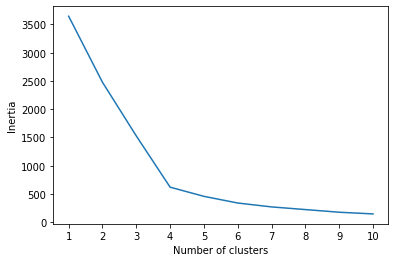

In [84]:
# Create the Elbow Curve using hvPlot
# Creating the Elbow Curve
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
plt.plot(df_elbow['k'], df_elbow['inertia'])
plt.xticks(range(1,11))
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [85]:
from sklearn import cluster
# Initialize the K-Means model
model = KMeans(n_clusters=5, random_state=1)

# Train the model
model.fit(crypto_pca_df)

# Predict clusters
predictions = model.predict(crypto_pca_df)

crypto_pca_df["class"] = model.labels_
crypto_pca_df.head()


# Create return DataFrame with predicted clusters
merged_df = crypto_df.join(coin_name_df, how='inner')

clustered_df = merged_df.join(crypto_pca_df, how='inner')

clustered_df

,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply,CoinName,PC 1,PC 2,PC 3,class
42,Scrypt,PoW/PoS,4.199995e+01,4.200000e+01,42 Coin,-0.328527,0.964292,-0.622849,4
404,Scrypt,PoW/PoS,1.055185e+09,5.320000e+08,404Coin,-0.311831,0.963973,-0.623151,4
1337,X13,PoW/PoS,2.927942e+10,3.141593e+11,EliteCoin,2.316472,1.357661,-0.703367,1
BTC,SHA-256,PoW,1.792718e+07,2.100000e+07,Bitcoin,-0.141159,-1.289653,0.219132,0
ETH,Ethash,PoW,1.076842e+08,0.000000e+00,Ethereum,-0.153801,-1.929644,0.435359,0
...,...,...,...,...,...,...,...,...,...
ZEPH,SHA-256,DPoS,2.000000e+09,2.000000e+09,ZEPHYR,2.468436,1.172108,-0.232412,1
GAP,Scrypt,PoW/PoS,1.493105e+07,2.500000e+08,Gapcoin,-0.326569,0.964112,-0.622849,4
BDX,CryptoNight,PoW,9.802226e+08,1.400223e+09,Beldex,0.321512,-2.274979,0.490636,0
ZEN,Equihash,PoW,7.296538e+06,2.100000e+07,Horizen,-0.149559,-2.027182,0.430551,0


In [86]:
cols = list(clustered_df.columns.values)
new_cols = ['Algorithm',
 'ProofType',
 'TotalCoinsMined',
 'TotalCoinSupply',
 'PC 1',
 'PC 2',
 'PC 3',
 'CoinName',
 'class']

In [87]:
clustered_df = clustered_df.reindex(columns=new_cols)
clustered_df

,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply,PC 1,PC 2,PC 3,CoinName,class
42,Scrypt,PoW/PoS,4.199995e+01,4.200000e+01,-0.328527,0.964292,-0.622849,42 Coin,4
404,Scrypt,PoW/PoS,1.055185e+09,5.320000e+08,-0.311831,0.963973,-0.623151,404Coin,4
1337,X13,PoW/PoS,2.927942e+10,3.141593e+11,2.316472,1.357661,-0.703367,EliteCoin,1
BTC,SHA-256,PoW,1.792718e+07,2.100000e+07,-0.141159,-1.289653,0.219132,Bitcoin,0
ETH,Ethash,PoW,1.076842e+08,0.000000e+00,-0.153801,-1.929644,0.435359,Ethereum,0
...,...,...,...,...,...,...,...,...,...
ZEPH,SHA-256,DPoS,2.000000e+09,2.000000e+09,2.468436,1.172108,-0.232412,ZEPHYR,1
GAP,Scrypt,PoW/PoS,1.493105e+07,2.500000e+08,-0.326569,0.964112,-0.622849,Gapcoin,4
BDX,CryptoNight,PoW,9.802226e+08,1.400223e+09,0.321512,-2.274979,0.490636,Beldex,0
ZEN,Equihash,PoW,7.296538e+06,2.100000e+07,-0.149559,-2.027182,0.430551,Horizen,0


In [106]:
print(clustered_df.count)

<bound method DataFrame.count of         Algorithm ProofType  TotalCoinsMined  TotalCoinSupply      PC 1  \
42         Scrypt   PoW/PoS     4.199995e+01     4.200000e+01 -0.328527   
404        Scrypt   PoW/PoS     1.055185e+09     5.320000e+08 -0.311831   
1337          X13   PoW/PoS     2.927942e+10     3.141593e+11  2.316472   
BTC       SHA-256       PoW     1.792718e+07     2.100000e+07 -0.141159   
ETH        Ethash       PoW     1.076842e+08     0.000000e+00 -0.153801   
...           ...       ...              ...              ...       ...   
ZEPH      SHA-256      DPoS     2.000000e+09     2.000000e+09  2.468436   
GAP        Scrypt   PoW/PoS     1.493105e+07     2.500000e+08 -0.326569   
BDX   CryptoNight       PoW     9.802226e+08     1.400223e+09  0.321512   
ZEN      Equihash       PoW     7.296538e+06     2.100000e+07 -0.149559   
XBC        Scrypt       PoS     1.283270e+05     1.000000e+06 -0.291986   

          PC 2      PC 3     CoinName  class  
42    0.964292 -0.6

### Visualizing Results

#### Scatter Plot with Tradable Cryptocurrencies

In [116]:
# Scale data to create the scatter plot
scaled_supply =MinMaxScaler().fit_transform(clustered_df[["TotalCoinSupply"]])
scaled_mined =MinMaxScaler().fit_transform(clustered_df[["TotalCoinsMined"]])

In [118]:
clustered_df['TotalCoinsMined'] = scaled_mined
clustered_df['TotalCoinSupply'] = scaled_supply

In [119]:
clustered_df.hvplot.scatter(x="TotalCoinsMined", y="TotalCoinSupply", by="class",hover_cols = ["CoinName"])

:NdOverlay   [class]
   :Scatter   [TotalCoinsMined]   (TotalCoinSupply,CoinName)

#### Table of Tradable Cryptocurrencies

In [120]:
# Table with tradable cryptos
z = clustered_df.hvplot.table(columns=['CoinName', 'Algorithm', 'ProofType', 'TotalCoinSupply', 'TotalCoinsMined'], width=900)
z

:Table   [CoinName,Algorithm,ProofType,TotalCoinSupply,TotalCoinsMined]

In [121]:
# Print the total number of tradable cryptocurrencies
clustered_df.hvplot(
    kind="scatter", 
    x="TotalCoinsMined", 
    y="TotalCoinSupply", 
    c='class', 
    colormap="viridis", 
    hover_cols=['CoinName']
)

:Scatter   [TotalCoinsMined]   (TotalCoinSupply,class,CoinName)